In [ ]:
!pip install vaderSentiment --quiet
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.pipeline import Pipeline
import joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("/content/youtube-comments.csv")
df.head()

,publishedAt,authorDisplayName,textDisplay,likeCount
0,2025-05-15T15:04:49Z,@fajarhamdani1134,Sangat betul...,0
1,2025-05-13T21:18:46Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0
2,2025-05-13T21:18:23Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0
3,2025-05-13T21:12:52Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0
4,2025-05-13T21:11:00Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0


#**DATA DESCRIPTION**

In [ ]:
df = df.rename(columns={'textDisplay': 'comment', 'likeCount': 'likes'})
df.head()

,publishedAt,authorDisplayName,comment,likes
0,2025-05-15T15:04:49Z,@fajarhamdani1134,Sangat betul...,0
1,2025-05-13T21:18:46Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0
2,2025-05-13T21:18:23Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0
3,2025-05-13T21:12:52Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0
4,2025-05-13T21:11:00Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0


In [ ]:
print("Ukuran dataset:", df.shape)

Ukuran dataset: (19686, 4)


In [ ]:
print("\nInfo kolom:")
df.info()


Info kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19686 entries, 0 to 19685
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   publishedAt        19686 non-null  object
 1   authorDisplayName  19684 non-null  object
 2   comment            19686 non-null  object
 3   likes              19686 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 615.3+ KB


In [ ]:
df.describe()

,likes
count,19686.000000
mean,3.239155
std,106.122095
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,10225.000000


In [ ]:
print("\nCek Nilai Kosong:")
print(df.isnull().sum())


Cek Nilai Kosong:
publishedAt          0
authorDisplayName    2
comment              0
likes                0
dtype: int64


In [ ]:
print("\nJumlah komentar unik:", df['comment'].nunique())
print("Jumlah komentar duplikat:", df.duplicated('comment').sum())


Jumlah komentar unik: 19297
Jumlah komentar duplikat: 389


###Sample Code

In [ ]:
# Hitung kuartil
Q1 = df['likes'].quantile(0.25)
Q3 = df['likes'].quantile(0.75)
IQR = Q3 - Q1

# Tentukan batas atas & bawah
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Hapus outlier berdasarkan IQR
df_nxt = df[(df['likes'] >= lower_bound) & (df['likes'] <= upper_bound)]

print("Data setelah menghapus outlier IQR:")
print(df_nxt['likes'].describe())

Data setelah menghapus outlier IQR:
count    16895.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: likes, dtype: float64


In [ ]:
df_nxt.describe()

,likes
count,16895.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


#**CLEANING DATA**

In [ ]:
df = df.dropna()
print("\nSetelah menghapus nilai kosong:")
print(df.isnull().sum())


Setelah menghapus nilai kosong:
publishedAt          0
authorDisplayName    0
comment              0
likes                0
dtype: int64


In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)       # hapus URL
    text = re.sub(r"[^a-zA-Z\s]", "", text)   # hapus angka dan simbol
    text = re.sub(r"\s+", " ", text)          # hapus spasi berlebih
    return text

df["cleaned"] = df["comment"].apply(clean_text)
df.head()

,publishedAt,authorDisplayName,comment,likes,cleaned
0,2025-05-15T15:04:49Z,@fajarhamdani1134,Sangat betul...,0,sangat betul
1,2025-05-13T21:18:46Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0,ternak mulyono manaaa ngertiiiibiangnya aja ga...
2,2025-05-13T21:18:23Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0,ternak mulyono manaaa ngertiiiibiangnya aja ga...
3,2025-05-13T21:12:52Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0,ternak mulyono manaaa ngertiiiibiangnya aja ga...
4,2025-05-13T21:11:00Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0,ternak mulyono manaaa ngertiiiibiangnya aja ga...


In [ ]:
df = df.drop_duplicates(subset="comment", keep="first")

In [ ]:
df.head()

,publishedAt,authorDisplayName,comment,likes,cleaned
0,2025-05-15T15:04:49Z,@fajarhamdani1134,Sangat betul...,0,sangat betul
1,2025-05-13T21:18:46Z,@SuponoPono-n5g,Ternak MULYONO manaaa ngertiiii......biangnya ...,0,ternak mulyono manaaa ngertiiiibiangnya aja ga...
5,2025-05-13T15:41:27Z,@BadariahAhmad-b7t,Kerja sawit di msia sudah middle upper class bro,0,kerja sawit di msia sudah middle upper class bro
6,2025-05-13T09:29:59Z,@mibaa7578,Seorang yg begitu bijak.. tahniah org muda.❤,0,seorang yg begitu bijak tahniah org muda
7,2025-05-13T06:34:59Z,@RobiRahmathidayat01,Parah 😂,0,parah


#**DATA EXPLORATION**
Dibawah ini adalah beberapa contoh data yang bisa digunakan contohnya yaitu seperti panjang suatu komentar, jumlah komentar per hari, dan beberapa perbandingan yang bisa digunakan.

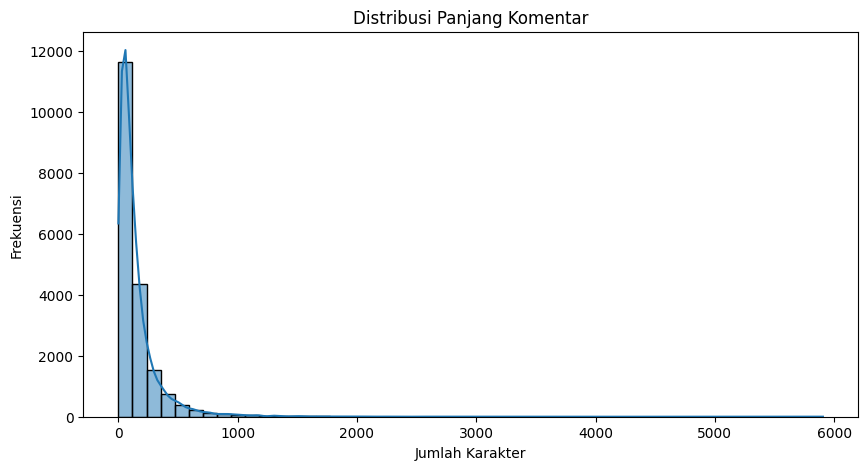

In [ ]:
df['comment_length'] = df['comment'].astype(str).apply(len)

plt.figure(figsize=(10,5))
sns.histplot(df['comment_length'], bins=50, kde=True)
plt.title('Distribusi Panjang Komentar')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Frekuensi')
plt.show()

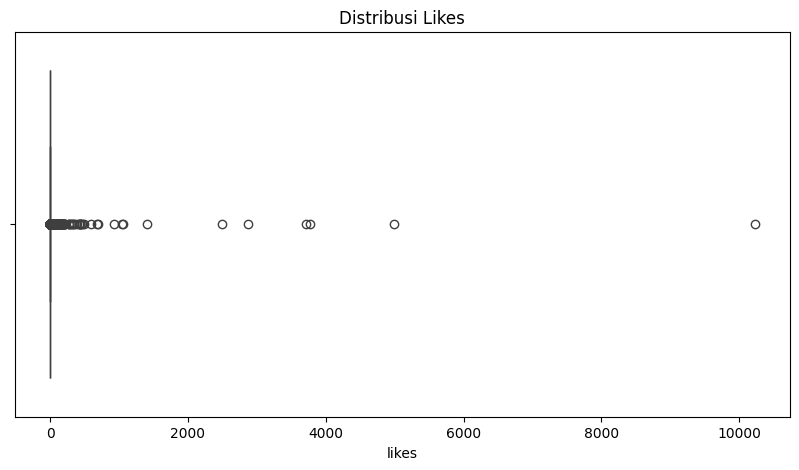

In [ ]:
if 'likes' in df.columns:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df, x='likes')
    plt.title('Distribusi Likes')
    plt.show()

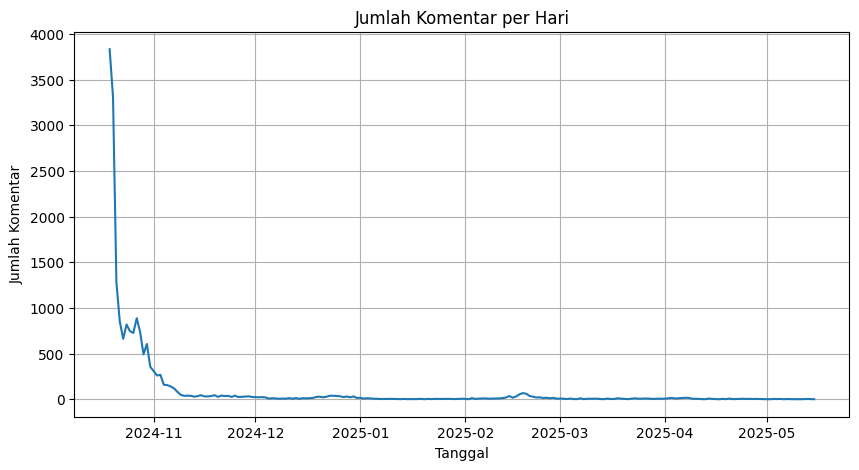

In [ ]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')

df['publishedAt'].dt.date.value_counts().sort_index().plot(kind='line', figsize=(10,5))
plt.title('Jumlah Komentar per Hari')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Komentar')
plt.grid(True)
plt.show()

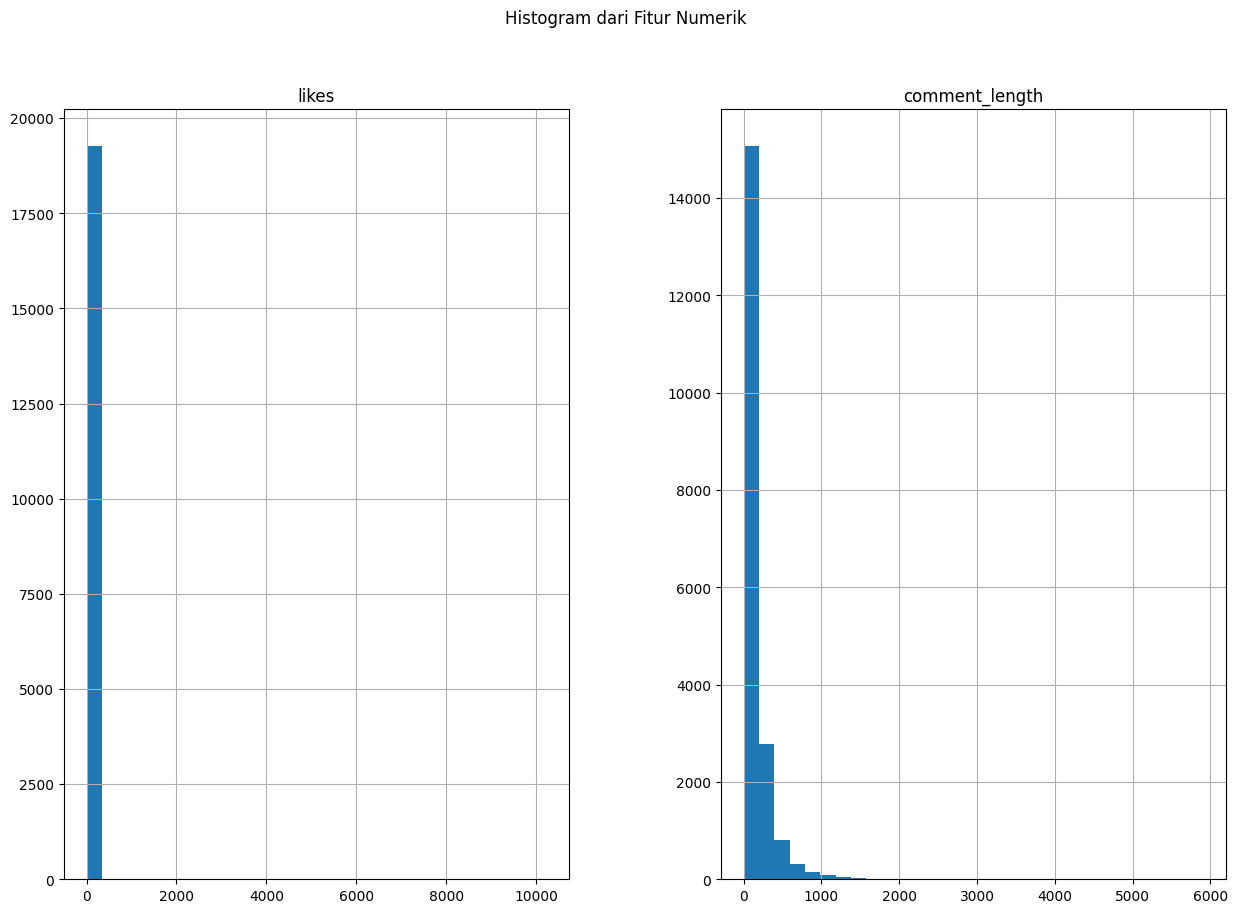

In [ ]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle('Histogram dari Fitur Numerik')
plt.show()

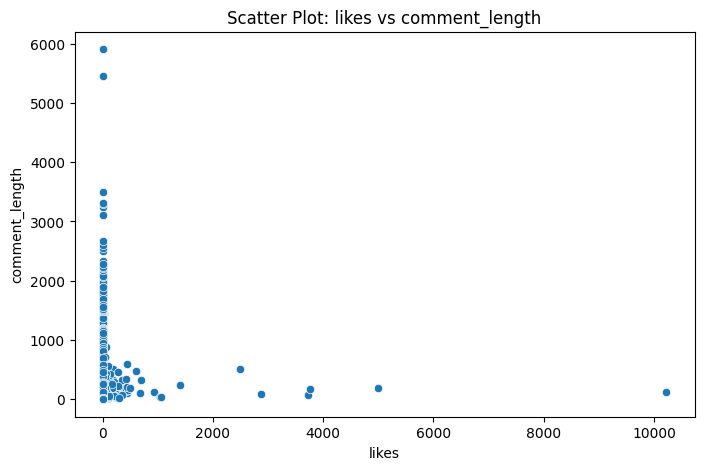

In [ ]:
if len(numeric_cols) >= 2:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=numeric_cols[0], y=numeric_cols[1])
    plt.title(f'Scatter Plot: {numeric_cols[0]} vs {numeric_cols[1]}')
    plt.show()

##**Deteksi Anomali**

In [ ]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    print(f"\n Deteksi outlier di kolom {col}: {len(outliers)} baris")


 Deteksi outlier di kolom likes: 2755 baris

 Deteksi outlier di kolom comment_length: 1551 baris


#**Analisis sentimen (VADER)**

In [ ]:
analyzer = SentimentIntensityAnalyzer()

###Sample Code

In [ ]:
def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['cleaned'].apply(get_sentiment)

<ipython-input-23-fc48f9b2df92>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='pastel')


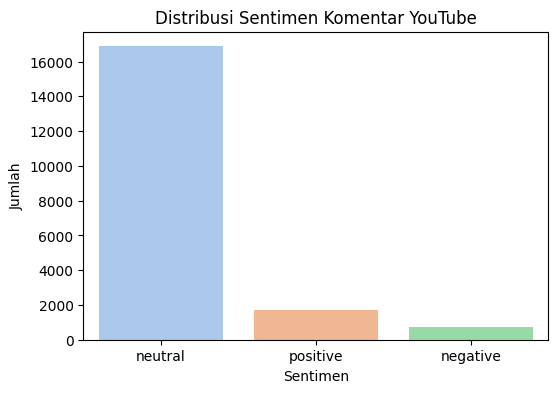

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', palette='pastel')
plt.title('Distribusi Sentimen Komentar YouTube')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

##**Without Neutral Sentiment**

In [ ]:
def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [ ]:
df['sentiment'] = df['cleaned'].apply(get_sentiment)

# Filter data tanpa sentimen neutral
df_model = df[df['sentiment'] != 'neutral']

X = df_model['cleaned']
y = df_model['sentiment']

Text(0, 0.5, 'Jumlah')

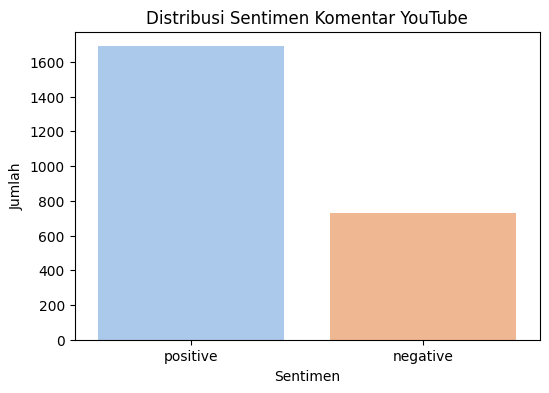

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_model, x='sentiment', palette='pastel', hue='sentiment', legend=False)
plt.title('Distribusi Sentimen Komentar YouTube')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')

#**MODELING**

In [ ]:
# TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

##Perbandingan Beberapa Metode


--- Evaluasi Model: LinearSVC ---
              precision    recall  f1-score   support

    negative       0.86      0.59      0.70       156
    positive       0.83      0.95      0.89       328

    accuracy                           0.84       484
   macro avg       0.85      0.77      0.79       484
weighted avg       0.84      0.84      0.83       484



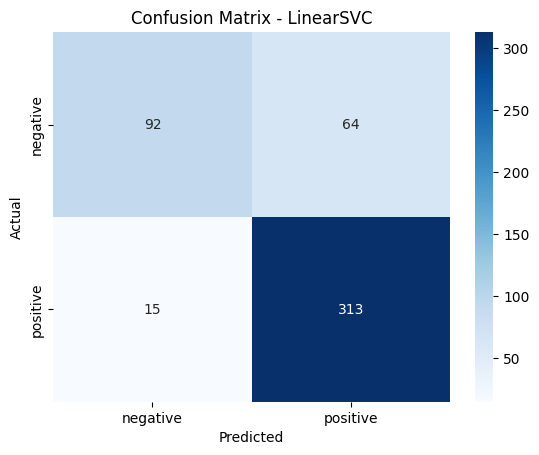


--- Evaluasi Model: Naive Bayes ---
              precision    recall  f1-score   support

    negative       1.00      0.02      0.04       156
    positive       0.68      1.00      0.81       328

    accuracy                           0.68       484
   macro avg       0.84      0.51      0.42       484
weighted avg       0.78      0.68      0.56       484



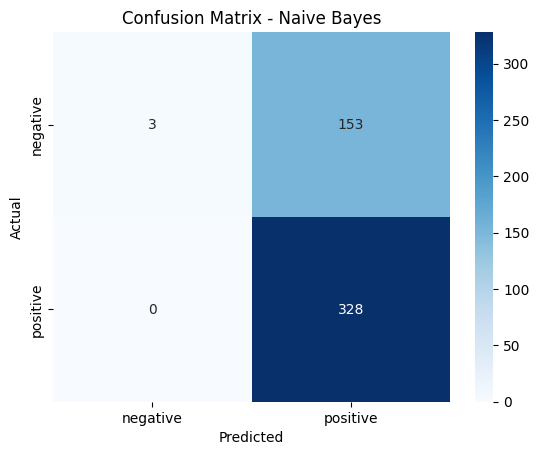


--- Evaluasi Model: Logistic Regression ---
              precision    recall  f1-score   support

    negative       0.97      0.22      0.36       156
    positive       0.73      1.00      0.84       328

    accuracy                           0.75       484
   macro avg       0.85      0.61      0.60       484
weighted avg       0.81      0.75      0.69       484



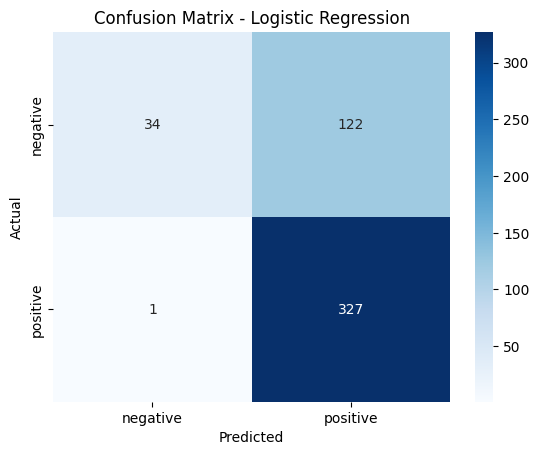


--- Evaluasi Model: Random Forest ---
              precision    recall  f1-score   support

    negative       0.93      0.45      0.61       156
    positive       0.79      0.98      0.88       328

    accuracy                           0.81       484
   macro avg       0.86      0.72      0.74       484
weighted avg       0.84      0.81      0.79       484



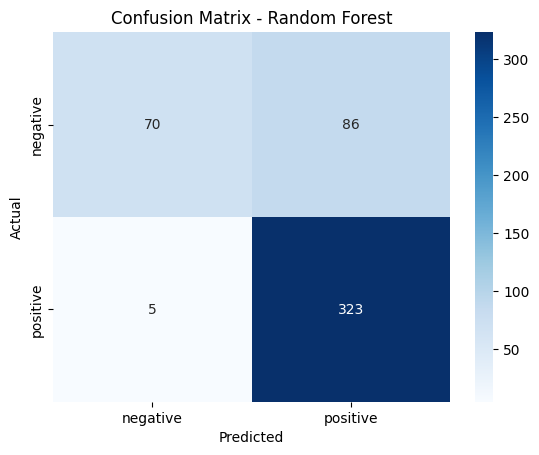


--- Evaluasi Model: KNN ---
              precision    recall  f1-score   support

    negative       0.78      0.31      0.45       156
    positive       0.75      0.96      0.84       328

    accuracy                           0.75       484
   macro avg       0.76      0.64      0.64       484
weighted avg       0.76      0.75      0.71       484



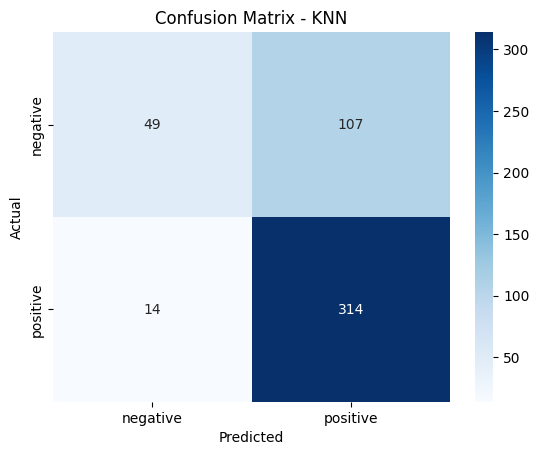


 Perbandingan Performa Model Klasifikasi:


,Accuracy,Precision,Recall,F1-Score
LinearSVC,83.68%,83.02%,95.43%,88.79%
Random Forest,81.20%,78.97%,98.48%,87.65%
Logistic Regression,74.59%,72.83%,99.70%,84.17%
KNN,75.00%,74.58%,95.73%,83.85%
Naive Bayes,68.39%,68.19%,100.00%,81.09%


In [ ]:
models = {
    "LinearSVC": LinearSVC(random_state=42, max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "KNN": KNeighborsClassifier()
}

results = {}
for name, model in models.items():
    print(f"\n--- Evaluasi Model: {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary', pos_label='positive')
    rec = recall_score(y_test, y_pred, average='binary', pos_label='positive')
    f1 = f1_score(y_test, y_pred, average='binary', pos_label='positive')

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    }

    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=['negative', 'positive'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'positive'],
                yticklabels=['negative', 'positive'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='F1-Score', ascending=False)

print("\n Perbandingan Performa Model Klasifikasi:")
display(results_df.style.background_gradient(cmap='Blues').format("{:.2%}"))

##**LinearSVC**
Menggunakan model LinearSVC dikarenakan memiliki hasil akurasi yang paling tinggi.

In [ ]:

model = LinearSVC(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Classification report lengkap
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.86      0.59      0.70       156
    positive       0.83      0.95      0.89       328

    accuracy                           0.84       484
   macro avg       0.85      0.77      0.79       484
weighted avg       0.84      0.84      0.83       484



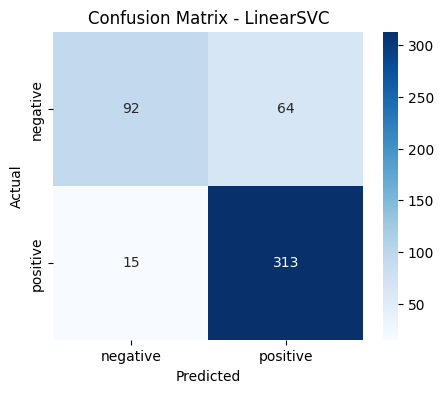

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - LinearSVC')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Evaluasi
print(f"Akurasi       : {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision     : {precision_score(y_test, y_pred, average='binary', pos_label='positive'):.2f}")
print(f"Recall        : {recall_score(y_test, y_pred, average='binary', pos_label='positive'):.2f}")
print(f"F1-Score      : {f1_score(y_test, y_pred, average='binary', pos_label='positive'):.2f}")

Akurasi       : 0.84
Precision     : 0.83
Recall        : 0.95
F1-Score      : 0.89


In [ ]:
joblib.dump(model, 'sentiment_model.pkl')

['sentiment_model.pkl']